<a href="https://colab.research.google.com/github/elkinkazan/itis-2025-ai-tools/blob/main/Task8_3d_reconstruction_Iliasova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# DO NOT MODIFY  !!!
# DO NOT EXECUTE !!!
!pip install --upgrade gspread pandas google-auth
import pandas as pd
import gspread
from google.colab import auth
from google.auth import default
from IPython.display import display
import random
# Authenticate and create the PyDrive client.
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [9]:
# FILL THIS
student_name = "ELVIRA ILIASOVA"
group_id = "11-451"


In [ ]:
# DO NOT MODIFY  !!!
# DO NOT EXECUTE !!!
SPREADSHEET_URL = "https://docs.google.com/spreadsheets/d/1Kfxj2eDFl7xQnXw7Fpb9bwghc65o8xf--VpNxrdWHaY/edit?gid=0#gid=0"
sh = gc.open_by_url(SPREADSHEET_URL)
worksheet = sh.sheet1

# Ensure header row exists
if not worksheet.get_all_values():
    worksheet.append_row(["Student Name", "Group","TaskID", "Score"])



In [ ]:
# MAIN NOTEBOOK GOES HERE
# DO NOT MODIFY  !!!
# DO NOT EXECUTE !!!
task_id = "Task8_3d_reconstruction"
score = 0
max_score = 20

# 🏠 Домашнее задание: 3D-реконструкция
В этом задании вы:
- Узнаете, как работает стереозрение
- Попробуете нейросетевую модель DPT
- Пройдёте автотесты по лекции

## 📘 Теоретические вопросы (ответьте письменно)
1. Что такое модель камеры pinhole?
2. Чем отличается Stereo Matching от Structure from Motion?
3. Что делает NeRF?
4. Как работает предсказание глубины по одному изображению?

1. **Пинхол** – это самая простая конструкция, которая позволяет при помощи камеры получать изображение. Технология заключается в том, что перед светочувствительным элементом вместо объектива устанавливается заглушка с отверстием в середине. Диаметр отверстия составляет около одного миллиметра. Свет проникает сквозь отверстие и равномерно распределяется во все стороны. Из-за того, что отверстие очень маленькое, светочувствительный элемент не засвечивается сразу. При помощи такой конструкции не получить чёткого изображения, но очертания объектов и отдельные элементы видны очень хорошо, так что даже людей можно различать на фотографиях.
**Пинхол** – это очень хорошая технология для креативных фотографов и тех, кто просто ищет новые фотографические приёмы.
Камера, работающая по технологии пинхол, существовала до появления фотоаппаратов с объективами. Первый снимок на пинхол-камеру был сделан в 1545 году астрономом Геммой Фрисиусом. В XIX столетии начали появляться камеры, которые в XX столетии были вытеснены более продвинутыми моделями с линзовыми объективами. Начиная с 1960 годов о технике пинхол снова вспомнили.
Свет, проходя через маленькое отверстие попадает на светочувствительную бумагу или плёнку. При этом оно переворачивается. Техника пинхол подобна работе современных камер или человеческого глаза с одним лишь отличием. Свет не фокусируется на плёнке при помощи линз. Из-за этого изображение получается размытым.

2. Есть такая интересная задача — построение 3D структуры по набору изображений (фотографий) — **Structure from Motion**. **Стереосопоставление** – это процесс определения соответствий между пикселями на двух изображениях, полученных стереокамерой, для восстановления 3D-структуры сцены. Этот процесс также известен как оценка диспарности.

3. NeRF изучает геометрию сцены, ее объекты и ракурсы. На их основе визуализируются фотореалистичные трехмерные изображения с новых точек обзора, а для заполнения пробелов в данных автоматически генерируются синтетические данные. NeRF (Neural Radiance Fields) — это метод, использующий нейросеть для воссоздания 3D-сцены по нескольким 2D-изображениям.
Вход: координаты точки в 3D + направление камеры (луча).

Выход: цвет (RGB) и плотность (оптическая плотность) этой точки.
С помощью volume rendering (объёмного рендеринга) NeRF "проецирует" эти предсказания обратно в изображение.

4. Предсказание глубины по одному изображению (monocular depth estimation) — это задача компьютерного зрения, где модель должна определить расстояние от камеры до каждого пикселя на изображении, используя только одну фотографию.
Основные подходы
Традиционные методы опирались на визуальные подсказки:

Перспектива и схождение линий
Относительные размеры объектов
Атмосферная дымка
Окклюзия (перекрытие объектов)
Текстурные градиенты

Современные методы используют глубокое обучение, особенно сверточные нейронные сети (CNN). Популярные архитектуры включают:

Encoder-Decoder структуры: энкодер извлекает признаки из изображения, декодер восстанавливает карту глубины
Multi-scale подходы: обработка изображения на разных масштабах для захвата как локальных, так и глобальных особенностей
Attention механизмы: фокусировка на важных областях изображения

## 🔧 Практика: Stereo Matching с OpenCV

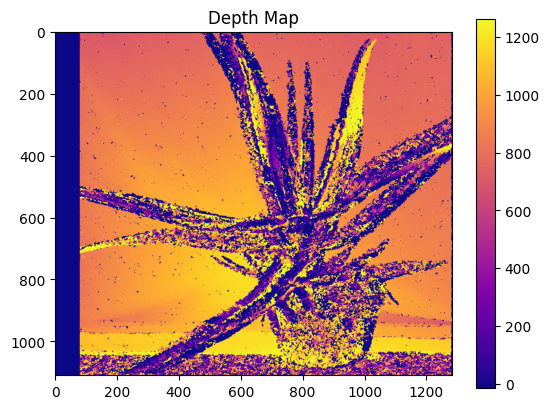

In [10]:
# Установим зависимости
!pip install opencv-python-headless matplotlib
import numpy as np
import cv2
import matplotlib.pyplot as plt
import requests
# Download the images using requests
def download_image(url):
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an exception for bad responses
    image_np = np.asarray(bytearray(response.content), dtype=np.uint8)
    return cv2.imdecode(image_np, cv2.IMREAD_GRAYSCALE)  # Decode as grayscale


imgL = download_image('https://raw.githubusercontent.com/opencv/opencv/master/samples/data/aloeL.jpg')
imgR = download_image('https://raw.githubusercontent.com/opencv/opencv/master/samples/data/aloeR.jpg')

stereo = cv2.StereoSGBM_create(minDisparity=0, numDisparities=16*5, blockSize=5)
depth = stereo.compute(imgL, imgR)

plt.imshow(depth, cmap='plasma')
plt.title('Depth Map')
plt.colorbar()
plt.show()

## 🔧 Практика: Предсказание глубины с DPT (MiDaS)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/dpt/feature_extraction_dpt.py:30: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.

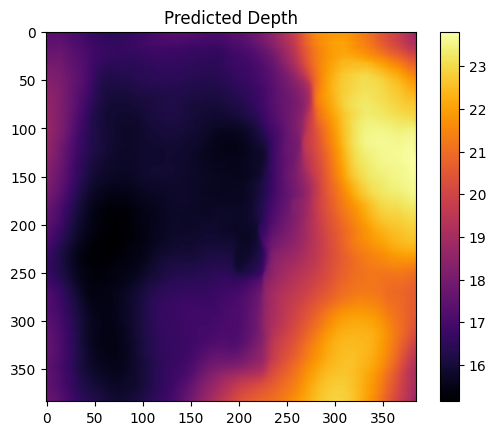

In [3]:
# Установим необходимые библиотеки
!pip install timm transformers
from PIL import Image
import torch
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# Загрузка изображения
url = 'https://images.pexels.com/photos/396547/pexels-photo-396547.jpeg'
image = Image.open(BytesIO(requests.get(url).content)).convert('RGB')

# Загрузка модели
extractor = DPTFeatureExtractor.from_pretrained('Intel/dpt-large')
model = DPTForDepthEstimation.from_pretrained('Intel/dpt-large')

inputs = extractor(images=image, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs)
depth = outputs.predicted_depth.squeeze().cpu().numpy()

# Визуализация
plt.imshow(depth, cmap='inferno')
plt.title('Predicted Depth')
plt.colorbar()
plt.show()

In [4]:
#Установите Open3D:
!pip install open3d


## Скачайте пример .ply файла облака точек:



In [21]:
import open3d as o3d
import urllib.request
pcd_url = "https://github.com/isl-org/open3d_downloads/releases/download/20220201-data/fragment.ply"
filename = "fragment.ply"
# download file
urllib.request.urlretrieve(pcd_url, filename)

('fragment.ply', <http.client.HTTPMessage at 0x7a1cab576fd0>)

## Загрузите и визуализируйте облако:

In [22]:

# Загрузка point cloud
pcd = o3d.io.read_point_cloud(filename)

# Проверка и визуализация
assert isinstance(pcd, o3d.geometry.PointCloud), "❌ Это не PointCloud объект"
assert len(pcd.points) > 0, "❌ Облако пустое"

print("✅ Облако точек успешно загружено!")
o3d.visualization.draw_geometries([pcd])

✅ Облако точек успешно загружено!
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [23]:
score = 0
assert isinstance(pcd, o3d.geometry.PointCloud)
score+=5
assert len(pcd.points) > 0
score+=5
print("✅ Облако точек успешно загружено")

✅ Облако точек успешно загружено


## Скачайте и загрузите облако точек

In [24]:
import open3d as o3d

pcd = o3d.io.read_point_cloud("fragment.ply")
pcd.estimate_normals()
print("✅ Нормали успешно оценены")

✅ Нормали успешно оценены


## Выполните реконструкцию поверхности:

In [25]:

# Применение реконструкции поверхности Поассона
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
    pcd, depth=9
)


## Отобразите результат

In [26]:
# Визуализация результатов
print("✅ Сетка и плотности получены!")
o3d.visualization.draw_geometries([mesh])

✅ Сетка и плотности получены!
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [27]:
assert isinstance(mesh, o3d.geometry.TriangleMesh)
score+=5
assert len(mesh.triangles) > 0
score+=5
print("✅ Меш успешно построен")

✅ Меш успешно построен


In [ ]:

# DO NOT MODIFY  !!!
# DO NOT EXECUTE !!!
# Save the result to Google Sheets
from datetime import datetime

# Get current date and time
now = datetime.now()
timestamp = now.strftime("%Y-%m-%d %H:%M:%S")
worksheet.append_row([student_name,group_id, task_id, score, timestamp])

print(f"Test completed! {student_name}, your score is {score}/{max_score}.")